In [4]:
%matplotlib inline
import IPython
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
import time

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [6]:
dataset_root_dir = "../dataset/BSDS300/images"

In [7]:
class NoisyBSDSDataset(td.Dataset):

    def __init__(self, root_dir, mode="train", image_size=(180, 180), sigma=30):
        super(NoisyBSDSDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir, mode)
        self.files = os.listdir(self.images_dir)

    def __len__(self):
        return len(self.files)

    def __repr__(self):
        return "NoisyBSDSDataset(mode={}, image_size={}, sigma={})".format(
            self.mode, self.image_size, self.sigma
        )

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        clean = Image.open(img_path).convert("RGB")
        # random crop
        i = np.random.randint(clean.size[0] - self.image_size[0])
        j = np.random.randint(clean.size[1] - self.image_size[1])

        clean = clean.crop(
            [i, j, i + self.image_size[0], j + self.image_size[1]])
        transform = tv.transforms.Compose(
            [
                # convert it to a tensor
                tv.transforms.ToTensor(),
                # normalize it to the range [−1, 1]
                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        clean = transform(clean)

        noisy = clean + 2 / 255 * self.sigma * torch.randn(clean.shape)
        return noisy, clean

In [9]:
def myimshow(image, ax=plt):
    image = image.to("cpu").numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis("off")
    return h

In [10]:
train_set = NoisyBSDSDataset(dataset_root_dir)
test_set = NoisyBSDSDataset(
    dataset_root_dir, mode="test", image_size=(320, 320))

image size is torch.Size([3, 320, 320]).


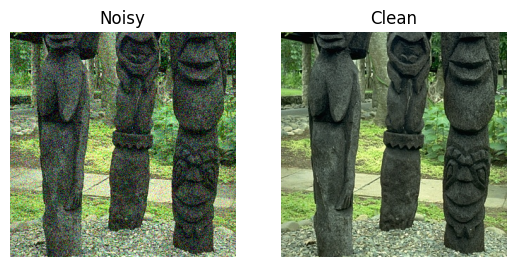

In [11]:
x = test_set[0]
fig, axes = plt.subplots(ncols=2)


myimshow(x[0], ax=axes[0])


axes[0].set_title("Noisy")


myimshow(x[1], ax=axes[1])


axes[1].set_title("Clean")


print(f"image size is {x[0].shape}.")

In [12]:
class NNRegressor(nt.NeuralNetwork):

    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()

    def criterion(self, y, d):
        return self.mse(y, d)

In [13]:
class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D

        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))

        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i + 1](h)))
        y = self.conv[D + 1](h) + x
        return y

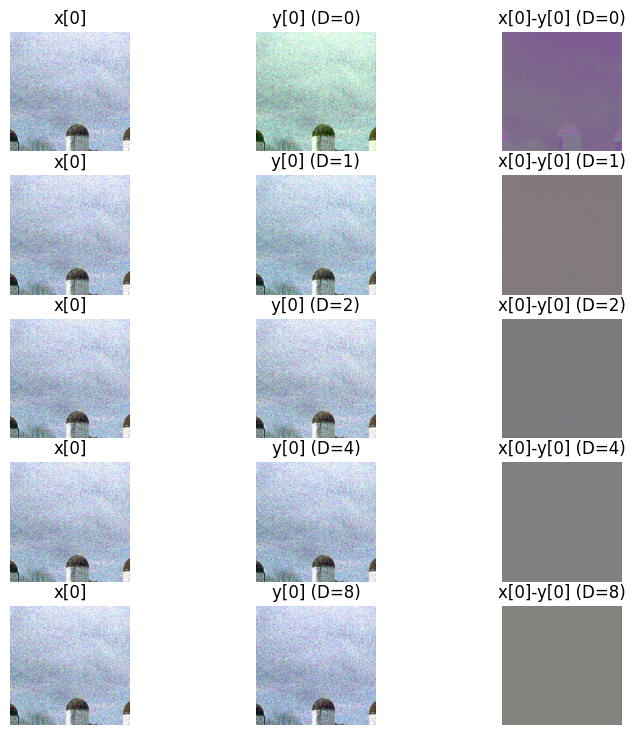

In [14]:
x, _ = train_set[-1]
x = x.unsqueeze(0).to(device)
Ds = [0, 1, 2, 4, 8]

fig, axes = plt.subplots(nrows=len(Ds), ncols=3, figsize=(9, 9))
for i in range(len(Ds)):
    with torch.no_grad():
        model = DnCNN(Ds[i]).to(device)
        y = model.forward(x)  # 4-d
    # 3-d
    myimshow(x[0], ax=axes[i][0])
    axes[i][0].set_title("x[0]")
    myimshow(y[0], ax=axes[i][1])
    axes[i][1].set_title(f"y[0] (D={Ds[i]})")
    myimshow(x[0] - y[0], ax=axes[i][2])
    axes[i][2].set_title(f"x[0]-y[0] (D={Ds[i]})")

In [16]:
class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D

        # convolution layers
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        # apply He's initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(
                self.conv[i].weight.data, nonlinearity="relu")

        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # initialize the weights of the Batch normalization layers
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i + 1](h)))
        y = self.conv[D + 1](h) + x
        return y

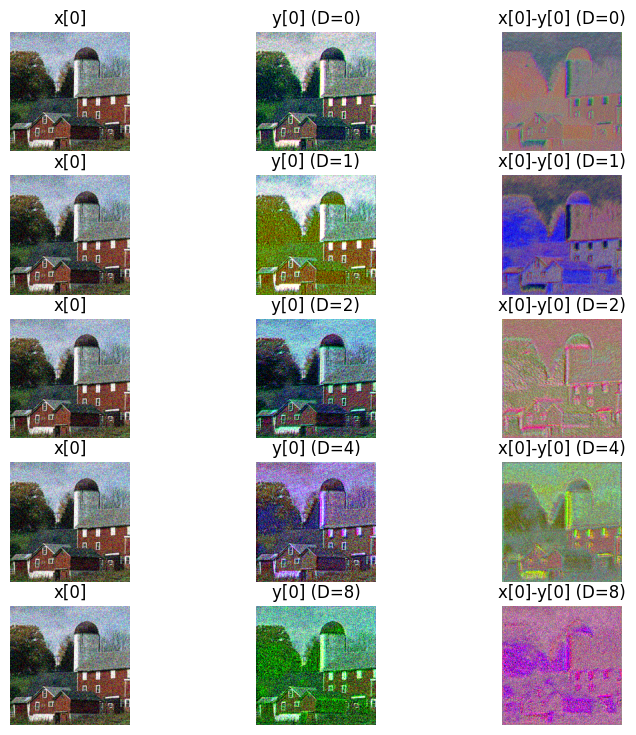

In [17]:
x, _ = train_set[-1]
x = x.unsqueeze(0).to(device)
Ds = [0, 1, 2, 4, 8]

fig, axes = plt.subplots(nrows=len(Ds), ncols=3, figsize=(9, 9))
for i in range(len(Ds)):
    with torch.no_grad():
        model = DnCNN(Ds[i]).to(device)
        y = model.forward(x)

    myimshow(x[0], ax=axes[i][0])
    axes[i][0].set_title("x[0]")
    myimshow(y[0], ax=axes[i][1])
    axes[i][1].set_title(f"y[0] (D={Ds[i]})")
    myimshow(x[0] - y[0], ax=axes[i][2])
    axes[i][2].set_title(f"x[0]-y[0] (D={Ds[i]})")

In [18]:
class DenoisingStatsManager(nt.StatsManager):

    def __init__(self):
        super(DenoisingStatsManager, self).__init__()

    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0

    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)
        n = x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3]
        self.running_psnr += 10 * torch.log10(4 * n / (torch.norm(y - d) ** 2))

    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        psnr = self.running_psnr / self.number_update
        return {"loss": loss, "PSNR": psnr.cpu()}

In [19]:
def plot(exp, fig, axes, noisy, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[None].to(net.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(noisy, ax=axes[0][0])
    axes[0][0].set_title("Noisy image")

    myimshow(denoised, ax=axes[0][1])
    axes[0][1].set_title("Denoised image")

    axes[1][0].plot(
        [exp.history[k][0]["loss"] for k in range(exp.epoch)], label="training loss"
    )
    axes[1][0].set_ylabel("Loss")
    axes[1][0].set_xlabel("Epoch")
    axes[1][0].legend()

    axes[1][1].plot(
        [exp.history[k][0]["PSNR"] for k in range(exp.epoch)], label="training psnr"
    )
    axes[1][1].set_ylabel("PSNR")
    axes[1][1].set_xlabel("Epoch")
    axes[1][1].legend()

    plt.tight_layout()
    fig.canvas.draw()

In [20]:
lr = 1e-3
net = DnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp1 = nt.Experiment(
    net,
    train_set,
    test_set,
    adam,
    stats_manager,
    batch_size=4,
    output_dir="../checkpoints/denoising1",
    perform_validation_during_training=True,
)

Start/Continue training from epoch 0
Epoch 1 | Time: 137.80s | Training Loss: 0.049768 | Evaluation Loss: 0.027363
Epoch 2 | Time: 124.05s | Training Loss: 0.023685 | Evaluation Loss: 0.020642
Epoch 3 | Time: 130.75s | Training Loss: 0.019199 | Evaluation Loss: 0.017499
Epoch 4 | Time: 158.54s | Training Loss: 0.016565 | Evaluation Loss: 0.015376
Epoch 5 | Time: 157.70s | Training Loss: 0.014814 | Evaluation Loss: 0.013804
Epoch 6 | Time: 134.73s | Training Loss: 0.013293 | Evaluation Loss: 0.012517
Epoch 7 | Time: 122.83s | Training Loss: 0.012385 | Evaluation Loss: 0.011572
Epoch 8 | Time: 123.68s | Training Loss: 0.011636 | Evaluation Loss: 0.010902
Epoch 9 | Time: 124.00s | Training Loss: 0.010709 | Evaluation Loss: 0.010327
Epoch 10 | Time: 122.78s | Training Loss: 0.010176 | Evaluation Loss: 0.009834
Epoch 11 | Time: 122.84s | Training Loss: 0.009582 | Evaluation Loss: 0.009315
Epoch 12 | Time: 123.00s | Training Loss: 0.009201 | Evaluation Loss: 0.008914
Epoch 13 | Time: 121.95s

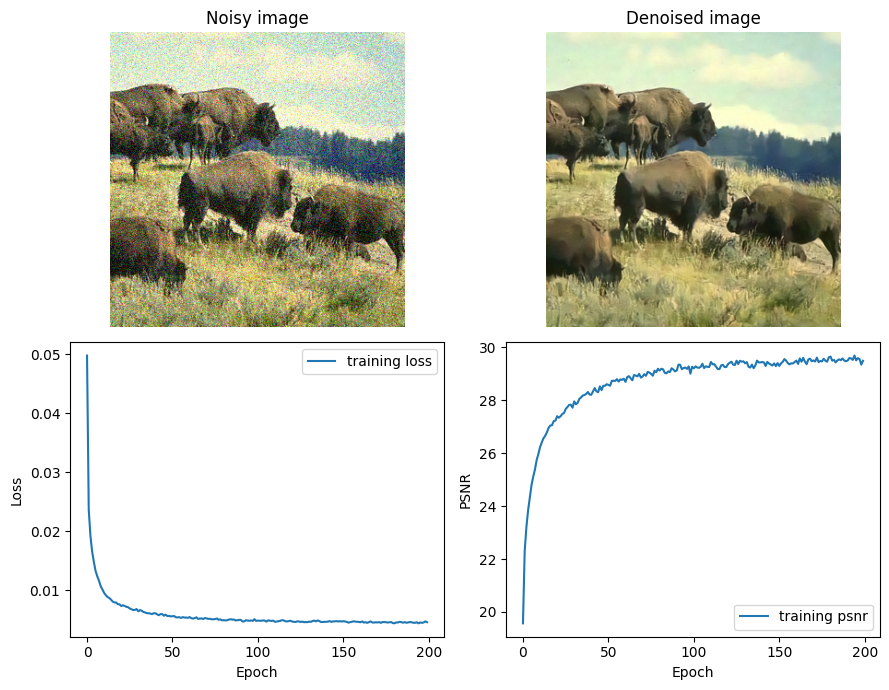

In [21]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
exp1.run(
    num_epochs=200,
    plot=lambda exp: plot(exp, fig=fig, axes=axes, noisy=test_set[73][0]),
)

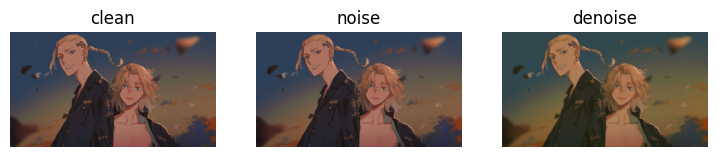

In [23]:
# Function to Test on custom images
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image


def myimshow(tensor_image, ax):
    image = tensor_image.permute(1, 2, 0).cpu().numpy()
    ax.imshow(image)
    ax.axis("off")


def denoise_custom_image(model, custom_image):
    # Define the necessary transformations
    transform = transforms.Compose([transforms.ToTensor()])

    # Convert the image to a tensor and unsqueeze to add batch dimension
    custom_image_tensor = transform(custom_image).unsqueeze(0).to(device)

    # Ensure the model is in evaluation mode
    model.eval()

    # Denoise the image
    with torch.no_grad():
        noisy_image = custom_image_tensor
        denoised_image = model(noisy_image)

    # Prepare images for display
    images = [
        custom_image_tensor.squeeze(0),
        noisy_image.squeeze(0),
        denoised_image.squeeze(0),
    ]
    titles = ["clean", "noise", "denoise"]

    # Display the images
    fig, axes = plt.subplots(ncols=3, figsize=(9, 5), sharex="all", sharey="all")
    for i, img in enumerate(images):
        myimshow(img, ax=axes[i])
        axes[i].set_title(titles[i])
    plt.show()


# Example of denoising a custom image
image_path = "../img.jpg"
custom_image = Image.open(image_path).convert(
    "RGB"
)  # Ensure the image is in RGB format
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming 'exp1.net' is your model
denoise_custom_image(exp1.net.to(device), custom_image)

### parameters of `DnCNN`


In [28]:
for name, param in model.named_parameters():
    print(name, param.size(), param.requires_grad)

conv.0.weight torch.Size([64, 3, 3, 3]) True
conv.0.bias torch.Size([64]) True
conv.1.weight torch.Size([64, 64, 3, 3]) True
conv.1.bias torch.Size([64]) True
conv.2.weight torch.Size([64, 64, 3, 3]) True
conv.2.bias torch.Size([64]) True
conv.3.weight torch.Size([64, 64, 3, 3]) True
conv.3.bias torch.Size([64]) True
conv.4.weight torch.Size([64, 64, 3, 3]) True
conv.4.bias torch.Size([64]) True
conv.5.weight torch.Size([64, 64, 3, 3]) True
conv.5.bias torch.Size([64]) True
conv.6.weight torch.Size([64, 64, 3, 3]) True
conv.6.bias torch.Size([64]) True
conv.7.weight torch.Size([64, 64, 3, 3]) True
conv.7.bias torch.Size([64]) True
conv.8.weight torch.Size([64, 64, 3, 3]) True
conv.8.bias torch.Size([64]) True
conv.9.weight torch.Size([3, 64, 3, 3]) True
conv.9.bias torch.Size([3]) True
bn.0.weight torch.Size([64]) True
bn.0.bias torch.Size([64]) True
bn.1.weight torch.Size([64]) True
bn.1.bias torch.Size([64]) True
bn.2.weight torch.Size([64]) True
bn.2.bias torch.Size([64]) True
bn.3.